In [1]:
import wandb
#from wandb import Api
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
#BASELINES = ["DBMS\n(Diff DB,Test Env)", "DBMS\n(Test DB,Test Env)"]

#BASELINES = ["DBMS (Transferable)", "DBMS (DB, Same Env)"]

BASELINES = ["DBMS"]
HUES = {}

HUES["DBMS"] = "Red"  # Red is a strong color, good for contrast.
#HUES["DBMS (DB, Same Env)"] = "Orange"  # Orange is distinct from red and provides good contrast.

# Your model
HUES["Factorized (Osprey)"] = "RoyalBlue"  # A bright and prominent shade of blue.

# Other GCN models
HUES["GCN (DB, New Env)"] = "LightGreen"  # A lighter shade for distinction from darker colors.
HUES["GCN (Transferable)"] = "Cyan"  # Cyan is visually distinct from blue and green.
HUES["GCN (DB, Same Env)"] = "LightGray"  # A neutral, unobtrusive color for the least focus.

# Factorized (Osprey) models
HUES["Factorized (Osprey)\n(No Pre-training)"] = "YellowGreen"  # A yellow-green shade for differentiation.

# GCN-Transformer models
HUES["GCN-Transformer (TestDB)"] = "SlateGray"  # A neutral color that doesn't dominate.

In [3]:
api = wandb.Api()

In [4]:
bruns = api.runs("pari/LatencyPredictor",
    {"$and": [
      {"config.alg": "dbms"},
      {"$or": [
            {"$and": [
                {"tags":"single-stack-final9-min-01-baseline"},
            ]},
      ]} 
    ]
    })

print(f"Found {len(bruns)} runs")

Found 2 runs


In [5]:
import time
start = time.time()

bdfs = []

cur_run = None
for run in bruns:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    bdfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(bdfs))

bdf = pd.concat(bdfs)
#bdf = bdf[bdf["config"] == "configs/baselines/config_dbms_imdb.yaml"]
print(len(bdf))

took:  0.011986970901489258
2
2


In [6]:
bdf[["Final-LatencyQError-test-mean", "Final-LatencyQError-test_unseen-mean", "Final-LatencyMSE-test_unseen-mean",  "dbms_fit_test"]]

,Final-LatencyQError-test-mean,Final-LatencyQError-test_unseen-mean,Final-LatencyMSE-test_unseen-mean,dbms_fit_test
0,11.114750,7.289393,7662.554844,1
0,8.965927,8.700900,12709.000026,0


In [7]:
#bdf = bdf[bdf["dbms_fit_test"] == 0]

In [8]:
runs = api.runs("pari/LatencyPredictor",
    {"$and": [
      {"$or": [
            {"$or": [
                {"tags": "single-stack-final9-min-01"},
            ]},
      ]} 
    ]
    })

print(f"Found {len(runs)} runs")

Found 46 runs


In [9]:
import time
start = time.time()

dfs = []

cur_run = None
for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(dfs))

took:  0.11890077590942383
42


In [10]:
df = pd.concat(dfs)

df1 = df[df["config"].str.contains("transfer")]
print("Num transferrable: ", len(df1))
df1 = df1[df1["feat_onehot"] == 0]
#df1['fixed_tr'] = df1['Tags'].apply(lambda x: any("transfer" in s for s in x))
#df1 = df1[df1['fixed_tr']]
print("Num transferrable: ", len(df1))

df2 = df[~(df["config"].str.contains("mt"))
         & (df["split_kind"] == "lt_type-query")
        ]

df = pd.concat([df1,df2])
df = pd.concat([df, bdf])
print(len(df))

df = pd.concat([df, bdf])
print(len(df))



Num transferrable:  12
Num transferrable:  6
38
40


In [11]:
set(df["alg"])

{'dbms', 'nn'}

In [12]:
# GCN, GCN-Transformer, GCN-Pretrained, GCN-Pretrained-Latent

PRETRAINED_NAME = False

def get_alg(row):
    if "dbms" == row["alg"] or "dbms-c" == row["alg"]:
        if row["dbms_fit_test"]:
            return "DBMS (DB, Same Env)"
        else:
            return "DBMS"
    
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    
    elif "avg" in row["config"]:
        return "GCN-Avg"
    
    elif row["arch"] == "gcn":
        if "train_local_model" in row:
            if "train_env_model" in row and str(row["train_env_model"]) != "nan" and row["train_env_model"]:
                print(row["train_env_model"])
                #return "GCN\n(Diff DB,Test Env)"
                return "GCN (Transferable)"
            elif str(row["train_local_model"]) == "nan" or not row["train_local_model"]:
                #return "GCN\n(Test DB,Diff Env)"
                return "GCN (DB, New Env)"
            else:
                #return "GCN\n(Test DB,Test Env)"
                return "GCN (DB, Same Env)"
        else:
            return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized (Osprey)\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized (Osprey)\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    
    elif "evals" in row["config"]:
        if row["sys_net_pretrained_fn"] == "models5/mixed_nostack_logfeats_cols.wt":
            return "Factorized (Osprey)"
        else:
            return row["sys_net_pretrained_fn"]
    else:
        return None
    
def get_final_alg(row):
    if "dbms" == row["alg"] or "dbms-c" == row["alg"]:
        if row["dbms_fit_test"]:
            return "DBMS (DB, Same Env)"
        else:
            return "DBMS"
    
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    
    elif "avg" in row["config"]:
        return "GCN-Avg"
    
    elif row["arch"] == "gcn":
        if "train_local_model" in row:
            if "train_env_model" in row and str(row["train_env_model"]) != "nan" and row["train_env_model"]:
                print(row["train_env_model"])
                #return "GCN\n(Diff DB,Test Env)"
                return "GCN (Transferable)"
            elif str(row["train_local_model"]) == "nan" or not row["train_local_model"]:
                #return "GCN\n(Test DB,Diff Env)"
                return "GCN (DB, New Env)"
            else:
                #return "GCN\n(Test DB,Test Env)"
                return "GCN (DB, Same Env)"
        else:
            return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized (Osprey)\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized (Osprey)\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    
    elif "evals" in row["config"]:
        if row["sys_net_pretrained_fn"] == "models5/mixed_nostack_logfeats_cols.wt":
            return "Factorized (Osprey)"
        else:
            return row["sys_net_pretrained_fn"]
    else:
        return None

    
def get_workload(row):
    if "dbms" in row["alg"].lower():
        return "IMDb"
    
    if "stack" in row["tags"]:
        return "Stack"
    elif "tpch" in row["tags"]:
        return "Tpch"
    elif "zdb" in row["tags"]:
        return "zdbs"
    else:
        return "IMDb"
    
    
df["Estimator"] = df.apply(lambda x: get_final_alg(x),axis=1)
df["alg"] = df.apply(lambda x: get_alg(x),axis=1)
df["workload"] = df.apply(lambda x: get_workload(x),axis=1)

2.0
3.0
5.0
4.0
1.0
6.0
2.0
3.0
5.0
4.0
1.0
6.0


In [13]:
df = df[df["alg"].notna()]

In [14]:
print(len(df))
print(set(df["num_instances"]))
print(set(df["seed"]))
print(set(df["config"]))
print(set(df["sys_net_pretrained_fn"]))
print(set(df["alg"]))
print(set(df["tags"]))
print(set(df["workload"]))
print(set(df["tags"]))
print(df.keys())

40
{1}
{0, 1, 2, 3, 4}
{'configs/evals/single/config_nostack_cols.yaml', 'configs/evals/single/config_nostack_nopretraining.yaml', 'configs/evals/single/config_nostack.yaml', 'configs/baselines/config_dbms_stack.yaml', 'configs/evals/single/config_nostack_transferable.yaml'}
{'models5/mixed_nostack_logfeats_cols.wt', 'models4/mixed_nostack_logfeats.wt', 'models4/concurrent_nostack_randomsplit_test90.wt', 'models4/mixed_nostack_logfeats_cols_randomsplit_test90.wt', None, 'models4/noimdb_log_nostatic_logfeats.wt'}
{'Factorized (Osprey)', 'GCN (Transferable)', 'GCN (DB, Same Env)', 'DBMS', 'DBMS (DB, Same Env)', 'models4/concurrent_nostack_randomsplit_test90.wt', 'Factorized (Osprey)\n(No Pre-training)', 'models4/mixed_nostack_logfeats_cols_randomsplit_test90.wt', 'GCN (DB, New Env)', 'GCN-Transformer (TestDB)'}
{'exp8_single_stack,exp14_single_stack', 'exp8_single_stack,exp14_single_stack,exp5_single_stats,exp9_single_tpch,exp4_single_ergast,exp1_single,exp2_single,exp3_single,exp7_singl

In [15]:
#df = df[df["alg"] != "DBMS-all"]
#df = df[df["alg"] != "GCN-Pretrained-Latent"]

In [16]:
print(len(df))
df.keys()

40


Index(['Tags', 'name', 'lr', 'alg', 'hl1', 'arch', 'seed', 'tags', 'config',
       'min_est',
       ...
       'train-LatencyQError', 'test-LatencyMSE', 'new_env_unseen-LatencyMSE',
       'test-LatencyQError', 'new_env_unseen-LatencyQError',
       'train-LatencyRelError', 'test-LatencyRelError', 'train-LatencyAE',
       'Estimator', 'workload'],
      dtype='object', length=158)

In [17]:
#df = df[df["weight_decay"] == 0.1]

In [18]:
pd.set_option('display.max_rows', 500)

tmp = df[df["num_instances"] == 1]
tmp[["seed", "num_instances", "alg", "extra_training", "weight_decay", "lr", "Final-LatencyQError-test-mean", "Final-LatencyAE-test-mean" , "weight_decay", "Final-LatencyMSE-test-mean", 
    "Final-LatencyQError-test-median", "Final-LatencyQError-test-99p"]].sort_values(by="seed")

,seed,num_instances,alg,extra_training,weight_decay,lr,Final-LatencyQError-test-mean,Final-LatencyAE-test-mean,weight_decay,Final-LatencyMSE-test-mean,Final-LatencyQError-test-median,Final-LatencyQError-test-99p
0,0,1,Factorized (Osprey),0,1,0.00010,5.531063,52.823837,1,12785.458446,2.926097,45.444883
0,0,1,GCN-Transformer (TestDB),0,1,0.00010,39.627789,171.372046,1,46100.500547,13.881525,353.676722
0,0,1,"GCN (DB, New Env)",0,1,0.00010,16.145909,81.840171,1,14668.933040,6.353484,144.768216
0,0,1,models4/mixed_nostack_logfeats_cols_randomspli...,0,1,0.00010,6.444190,51.956809,1,12028.409807,3.351441,42.237550
0,1,1,GCN (Transferable),0,1,0.00001,16.597684,49.913255,1,13872.306676,4.107641,153.383015
0,1,1,DBMS,None,1,0.00010,8.965927,55.158834,1,13162.602914,4.105437,84.752872
0,1,1,"DBMS (DB, Same Env)",0,1,0.00010,11.114750,60.250123,1,11621.450563,4.732120,110.887315
0,1,1,Factorized (Osprey),0,1,0.00010,5.110796,46.100554,1,12585.152437,2.568453,35.986446
0,1,1,GCN-Transformer (TestDB),0,1,0.00010,31.912909,127.717320,1,23500.241061,11.101856,335.826807
0,1,1,"GCN (DB, New Env)",0,1,0.00010,31.816176,132.999034,1,29018.065598,10.897637,337.293037


In [19]:
set(df["alg"])

{'DBMS',
 'DBMS (DB, Same Env)',
 'Factorized (Osprey)',
 'Factorized (Osprey)\n(No Pre-training)',
 'GCN (DB, New Env)',
 'GCN (DB, Same Env)',
 'GCN (Transferable)',
 'GCN-Transformer (TestDB)',
 'models4/concurrent_nostack_randomsplit_test90.wt',
 'models4/mixed_nostack_logfeats_cols_randomsplit_test90.wt'}

In [20]:
df.groupby(["Estimator"])["Final-LatencyQError-test_unseen-mean"].describe()

,count,mean,std,min,25%,50%,75%,max
Estimator,,,,,,,,
DBMS,2.0,8.700900,0.000000,8.700900,8.700900,8.700900,8.700900,8.700900
"DBMS (DB, Same Env)",2.0,7.289393,0.000000,7.289393,7.289393,7.289393,7.289393,7.289393
Factorized (Osprey),4.0,6.137230,0.650020,5.357841,5.736103,6.203555,6.604683,6.783970
Factorized (Osprey)\n(No Pre-training),4.0,11.395031,3.943214,6.566659,10.123559,11.394730,12.666202,16.224005
"GCN (DB, New Env)",4.0,20.747019,7.850178,11.742880,17.530525,20.196626,23.413120,30.851944
"GCN (DB, Same Env)",6.0,4.731250,0.475672,4.047765,4.482690,4.783456,4.908866,5.439721
GCN (Transferable),6.0,19.253328,0.615548,18.326699,19.067160,19.230618,19.444145,20.204037
GCN-Transformer (TestDB),4.0,23.253085,17.340442,8.470709,9.246773,20.203138,34.209449,44.135355
models4/concurrent_nostack_randomsplit_test90.wt,4.0,5.970263,1.452266,4.969687,5.220184,5.393076,6.143154,8.125212


In [21]:
FN_TMP = "NewInstances-{}-{}.pdf"

def plot_metrics(data, metric_median, metric_90p, metric_mean, title, prefix=""):
    fig, axs = plt.subplots(1, 3, figsize=(18,6))
    fig.suptitle(title)
    
    baseline_data = data[data['alg'] == "DBMS (instance-tuned)"]
    
    # Filter out the baseline data from the data being plotted
    data = data[data['alg'] != "DBMS (instance-tuned)"]
    
    if "MSE" in metric_mean:
        use_log = True
    else:
        use_log = False
    
    if not baseline_data.empty:
        baseline_median = baseline_data[metric_median].values[0]
        baseline_90p = baseline_data[metric_90p].values[0]
        baseline_mean = baseline_data[metric_mean].values[0]
    else:
        baseline_median = None
        baseline_90p = None
        baseline_mean = None

    # Plot for Median values
    sns.barplot(data=data, y=metric_median, x="num_instances", hue="alg", dodge=True, ax=axs[0])
    if baseline_median is not None:
        axs[0].axhline(baseline_median, color='r', linestyle='--', label='Baseline (Median)')
    axs[0].set_title('Median')

    if use_log:
        axs[0].set_yscale("log")
        
        
    # Plot for 90th Percentile values
    sns.barplot(data=data, y=metric_90p, x="num_instances", hue="alg", dodge=True, ax=axs[1])
    if baseline_median is not None:
        axs[1].axhline(baseline_90p, color='r', linestyle='--', label='Baseline (90th Percentile)')
    axs[1].set_title('90th Percentile')
    #if should_use_log_scale(data[metric_90p]):
        
    if use_log:
        axs[1].set_yscale("log")

    # Plot for Mean values
    sns.barplot(data=data, y=metric_mean, x="num_instances", hue="alg", dodge=True, ax=axs[2])
    if baseline_median is not None:
        axs[2].axhline(baseline_mean, color='r', linestyle='--', label='Baseline (Mean)')
        
    axs[2].set_title('Mean')
    if use_log:
        axs[2].set_yscale("log")


    # Remove individual legends and add a single legend at the top
    for ax in axs:
        ax.get_legend().remove()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles + [axs[0].lines[0]], labels + ['Baseline'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.10), ncol=len(handles) + 1)

    # Finalize the plot and save
    plt.tight_layout()
    fn = FN_TMP.format(prefix + "Stack", title.replace(' ', '-'))
    print(fn)
    plt.savefig(fn, bbox_inches="tight")


In [22]:
# tmp = df
# # Plot for MSE
# plot_metrics(tmp, 
#              'Final-LatencyMSE-test-median', 
#              'Final-LatencyMSE-test-90p', 
#              'Final-LatencyMSE-test-mean',
#              'Latency MSE', 
#              prefix="SeenQ-")

# # Plot for Q-Error
# plot_metrics(tmp, 
#              'Final-LatencyQError-test-median', 
#              'Final-LatencyQError-test-90p', 
#              'Final-LatencyQError-test-mean',
#              'Latency Q-Error',
#               prefix="SeenQ-")

# plot_metrics(tmp, 
#              'Final-LatencyRelError-test-median', 
#              'Final-LatencyRelError-test-90p', 
#              'Final-LatencyRelError-test-mean',
#              'Latency Relative Error',
#              prefix="SeenQ-")

# # Plot for AE
# plot_metrics(tmp, 
#              'Final-LatencyAE-test-median', 
#              'Final-LatencyAE-test-90p', 
#              'Final-LatencyAE-test-mean',
#              'Latency Absolute Error',
#               prefix="SeenQ-")


In [23]:
# tmp = df
# # Plot for MSE
# plot_metrics(tmp, 
#              'Final-LatencyMSE-test_unseen-median', 
#              'Final-LatencyMSE-test_unseen-90p', 
#              'Final-LatencyMSE-test_unseen-mean',
#              'Latency MSE',
#              prefix="UnseenQ")
    

# # Plot for Q-Error
# plot_metrics(tmp, 
#              'Final-LatencyQError-test_unseen-median', 
#              'Final-LatencyQError-test_unseen-90p', 
#              'Final-LatencyQError-test_unseen-mean',
#              'Latency Q-Error',
#                  prefix="UnseenQ")

# plot_metrics(tmp, 
#              'Final-LatencyRelError-test_unseen-median', 
#              'Final-LatencyRelError-test_unseen-90p', 
#              'Final-LatencyRelError-test_unseen-mean',
#              'Latency Relative Error',
#                     prefix="UnseenQ")

# # Plot for AE
# plot_metrics(tmp, 
#              'Final-LatencyAE-test_unseen-median', 
#              'Final-LatencyAE-test_unseen-90p', 
#              'Final-LatencyAE-test_unseen-mean',
#              'Latency Absolute Error',
#                  prefix="UnseenQ")


In [29]:
# # import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import matplotlib.patches as mpatches

# #ORDER = ["GCN", "GCN-Transformer", "Pretrained Environment Transformer"]
# ORDER = ["GCN", "GCN-Transformer", "GCN (Test Instance Specialized)", "Pretrained Environment Transformer"]

# # Assuming df, BASELINES, HUES, and ORDER are defined somewhere in your script

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

# # Manually create legend handles for the bar plots
# bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

# # First subplot
# ax = axs[0]

# # Plot the bars
# sns.barplot(data=df, x="Estimator", 
#             y='Final-LatencyQError-test_unseen-median', 
#             hue="Estimator", 
#             palette=HUES,
#             order=ORDER,
#             dodge=False, ax=ax)

# # Baseline lines
# baseline_handles = []
# for estb in BASELINES:
#     tmp = df[df["Estimator"] == estb]
#     if len(tmp) == 0:
#         continue
#     bmedian = tmp['Final-LatencyQError-test_unseen-median'].mean()
#     line = ax.axhline(bmedian, color=HUES[estb], linestyle='--')
#     baseline_handles.append(line)

# ax.set_xlabel("")
# ax.set_xticklabels([])
# ax.set_ylabel("Median QError", fontsize=16)
# ax.tick_params(axis='y', labelsize=14)  # Set the font size to 12 for y-axis ticks

# ax.legend().remove()  # Remove the auto-generated legend

# # Second subplot
# ax = axs[1]

# sns.barplot(data=df, x="Estimator", 
#             y='Final-LatencyQError-test_unseen-mean', 
#             hue="Estimator", 
#             palette=HUES,
#             order=ORDER,
#             dodge=False, ax=ax)

# ax.set_xticklabels([])
# ax.set_xlabel("")
# ax.set_ylabel("Mean QError", fontsize=16)
# ax.tick_params(axis='y', labelsize=14)  # Set the font size to 12 for y-axis ticks

# for estb in BASELINES:
#     tmp = df[df["Estimator"] == estb]
#     if len(tmp) == 0:
#         continue
#     bmean = tmp['Final-LatencyQError-test_unseen-mean'].mean()
#     ax.axhline(bmean, color=HUES[estb], linestyle='--')

# ax.legend().remove()  # Remove the auto-generated legend

# # Manually create the legend
# if baseline_handles:
#     custom_handles = bar_handles + baseline_handles 
#     custom_labels = ORDER + ['DBMS', 'DBMS (test data)']
# else:
#     custom_handles = bar_handles
#     custom_labels = ORDER

# fig.legend(handles=custom_handles, labels=custom_labels, 
#            loc='upper center', 
#            ncol=3, bbox_to_anchor=(0.5, 1.10),
#            frameon=False)

# plt.tight_layout()
# plt.savefig("EvalSingle-Stack.pdf", bbox_inches="tight")

22


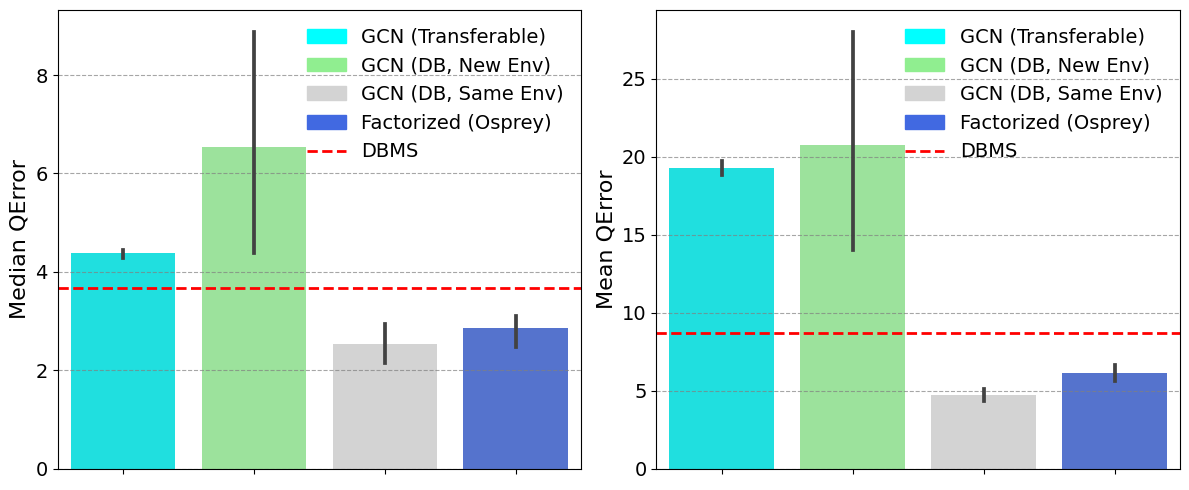

In [40]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

ORDER = ["GCN (Transferable)", "GCN (DB, New Env)", "GCN (DB, Same Env)",
         "Factorized (Osprey)"]

# Assuming df, BASELINES, HUES, and ORDER are defined somewhere in your script

tmp = df[df["Estimator"].isin(ORDER+BASELINES)]
print(len(tmp))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Manually create legend handles for the bar plots
bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

# First subplot
ax = axs[0]

# Plot the bars
sns.barplot(data=tmp, x="Estimator", 
            y='Final-LatencyQError-test_unseen-median', 
            hue="Estimator", 
            palette=HUES,
            order=ORDER,
            dodge=False, ax=ax)

# Baseline lines
baseline_handles = []
for estb in BASELINES:
    tmp2 = tmp[tmp["Estimator"] == estb]
    if len(tmp2) == 0:
        continue
    bmedian = tmp2['Final-LatencyQError-test_unseen-median'].mean()
    line = ax.axhline(bmedian, color=HUES[estb], linestyle='--', lw=2.0)
    baseline_handles.append(line)
    
# Manually create the legend
if baseline_handles:
    custom_handles = bar_handles + baseline_handles 
    custom_labels = ORDER + BASELINES
else:
    custom_handles = bar_handles
    custom_labels = ORDER

ax.set_xlabel("")
ax.set_xticklabels([])
ax.set_ylabel("Median QError", fontsize=16)
ax.tick_params(axis='y', labelsize=14)  # Set the font size to 12 for y-axis ticks

#ax.set_ylim([1, 10])

#ax.legend().remove()  # Remove the auto-generated legend
#ax.spines['top'].set_visible(False) 

ax.legend(handles=custom_handles, labels=custom_labels, 
           loc='upper right', 
           fontsize=14,
           ncol=1, 
           #bbox_to_anchor=(0.35, 0.95),
           frameon=False)

# Add horizontal gridlines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

# Make only bottom and left spines visible
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

# Second subplot
ax = axs[1]

sns.barplot(data=tmp, x="Estimator", 
            y='Final-LatencyQError-test_unseen-mean', 
            hue="Estimator", 
            palette=HUES,
            order=ORDER,
            dodge=False, ax=ax)

ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("Mean QError", fontsize=16)
ax.tick_params(axis='y', labelsize=14)  # Set the font size to 12 for y-axis ticks

for estb in BASELINES:
    tmp2 = tmp[tmp["Estimator"] == estb]
    if len(tmp2) == 0:
        continue
    bmean = tmp2['Final-LatencyQError-test_unseen-mean'].mean()
    ax.axhline(bmean, color=HUES[estb], linestyle='--', lw=2.0)
    
#ax.spines['top'].set_visible(False) 
    
#ax.set_ylim([1, 50])

ax.legend().remove()  # Remove the auto-generated legend


ax.legend(handles=custom_handles, labels=custom_labels, 
           loc='upper right', 
           fontsize=14,
           ncol=1, 
           frameon=False)

# Add horizontal gridlines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

# Make only bottom and left spines visible
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("EvalSingle-Stack.pdf", bbox_inches="tight")

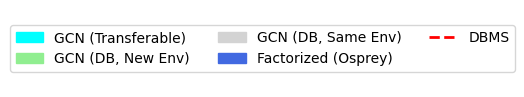

In [46]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import matplotlib.patches as mpatches

# ORDER = ["GCN (Transferable)", "GCN (DB, New Env)", "GCN (DB, Same Env)",
#          "Factorized (Osprey)"]

# # Assuming df, BASELINES, HUES, and ORDER are defined somewhere in your script

# tmp = df[df["Estimator"].isin(ORDER+BASELINES)]
# print(len(tmp))
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# # Manually create legend handles for the bar plots
# bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

# # First subplot
# ax = axs[0]

# # Plot the bars
# sns.barplot(data=tmp, x="Estimator", 
#             y='Final-LatencyQError-test_unseen-median', 
#             hue="Estimator", 
#             palette=HUES,
#             order=ORDER,
#             dodge=False, ax=ax)

# # Baseline lines
# baseline_handles = []
# for estb in BASELINES:
#     tmp2 = tmp[tmp["Estimator"] == estb]
#     if len(tmp2) == 0:
#         continue
#     bmedian = tmp2['Final-LatencyQError-test_unseen-median'].mean()
#     line = ax.axhline(bmedian, color=HUES[estb], linestyle='--', lw=2.0)
#     baseline_handles.append(line)
    
# # Manually create the legend
# if baseline_handles:
#     custom_handles = bar_handles + baseline_handles 
#     custom_labels = ORDER + BASELINES
# else:
#     custom_handles = bar_handles
#     custom_labels = ORDER

# ax.set_xlabel("")
# ax.set_xticklabels([])
# ax.set_ylabel("Median QError", fontsize=16)
# ax.tick_params(axis='y', labelsize=14)  # Set the font size to 12 for y-axis ticks

# #ax.set_ylim([1, 10])

# #ax.legend().remove()  # Remove the auto-generated legend
# #ax.spines['top'].set_visible(False) 

# ax.legend(handles=custom_handles, labels=custom_labels, 
#            loc='upper right', 
#            fontsize=14,
#            ncol=1, 
#            #bbox_to_anchor=(0.35, 0.95),
#            frameon=False)

# # Add horizontal gridlines
# ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

# # Make only bottom and left spines visible
# #ax.spines['top'].set_visible(False)
# #ax.spines['right'].set_visible(False)

# # Second subplot
# ax = axs[1]

# sns.barplot(data=tmp, x="Estimator", 
#             y='Final-LatencyQError-test_unseen-mean', 
#             hue="Estimator", 
#             palette=HUES,
#             order=ORDER,
#             dodge=False, ax=ax)

# ax.set_xticklabels([])
# ax.set_xlabel("")
# ax.set_ylabel("Mean QError", fontsize=16)
# ax.tick_params(axis='y', labelsize=14)  # Set the font size to 12 for y-axis ticks

# for estb in BASELINES:
#     tmp2 = tmp[tmp["Estimator"] == estb]
#     if len(tmp2) == 0:
#         continue
#     bmean = tmp2['Final-LatencyQError-test_unseen-mean'].mean()
#     ax.axhline(bmean, color=HUES[estb], linestyle='--', lw=2.0)
    
#ax.spines['top'].set_visible(False) 
    
#ax.set_ylim([1, 50])

ax.legend().remove()  # Remove the auto-generated legend


# ax.legend(handles=custom_handles, labels=custom_labels, 
#            loc='upper right', 
#            fontsize=14,
#            ncol=1, 
#            frameon=False)

# # Add horizontal gridlines
# ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

# # Make only bottom and left spines visible
# #ax.spines['top'].set_visible(False)
# #ax.spines['right'].set_visible(False)

# plt.tight_layout()
# plt.savefig("EvalSingle-Stack.pdf", bbox_inches="tight")
# # Step 2: Extract the legend


# Extract handles and labels
#handles, labels = ax.get_legend_handles_labels()
handles,labels = custom_handles, custom_labels

# Step 3: Create a new figure for the legend
# Adjust the figure size as needed
fig_leg = plt.figure(figsize=(1, 1))  # Example size, adjust as needed
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles, labels, loc='center', ncols=3)
ax_leg.axis('off')
fig_leg.tight_layout()

# Step 5: Save the legend figure
# Adjust bbox_inches to reduce whitespace
fig_leg.savefig('legend.pdf', bbox_inches='tight')